In [ ]:
from ergochemics.mapping import get_reaction_center
from rdkit import Chem
from ergochemics.draw import draw_reaction, draw_molecule
from IPython.display import SVG
import numpy as np
import polars as pl

def get_lhs_block_rc(am_smarts: str) -> list[int]:
    return get_reaction_center(am_smarts, mode="combined")[0]

In [2]:
dummy_df = pl.DataFrame({
    "id": [1, 2, 3],
    "name": ["A", "B", "C"],
    "value": [10.5, 20.3, 30.7],
    "lists": [[1, 2], [3, 4], [5, 6]],
})
dummy_df

id,name,value,lists
i64,str,f64,list[i64]
1,"""A""",10.5,"[1, 2]"
2,"""B""",20.3,"[3, 4]"
3,"""C""",30.7,"[5, 6]"


In [3]:
prs = pl.read_parquet(
    "/home/stef/quest_data/bottle/results/test/predicted_reactions.parquet"
)
prs.head()

id,smarts,am_smarts,dxgb_label,rxn_sims,analogue_ids,rules
str,str,str,i32,list[f32],list[str],list[str]
"""R86f73d66a5e7ccc343a1c8988fa04…","""O=C(O)CCC(=O)C(=O)O.N>>NC(=O)C…","""[O:1]=[C:2]([OH:3])[CH2:4][CH2…",1,"[1.0, 0.833333, … 0.5]","[""8960"", ""9418"", … ""15459""]","[""mechinferred_dt_98_rules:350""]"
"""Rcff9988697ea87445431b4f58d197…","""NC(=O)CCC(=O)C(=O)O.NC(CCC(=O)…","""[NH2:1][C:2](=[O:3])[CH2:4][CH…",1,"[0.869565, 0.869565, … 0.382692]","[""7864"", ""11791"", … ""16111""]","[""mechinferred_dt_98_rules:49""]"
"""R3aaeb8ef1e95350c5ba3d76d5f102…","""NC(=O)CCC(=O)C(=O)O.NC(=O)C1=C…","""[NH2:1][C:2](=[O:3])[CH2:4][CH…",1,"[0.976744, 0.976744, … 0.781661]","[""2451"", ""5654"", … ""9926""]","[""mechinferred_dt_98_rules:478""]"
"""Rffa3661ce89525930905fb09eac8d…","""NC(=O)CCC(=O)C(=O)O.NC(=O)CCC(…","""[NH2:1][C:2](=[O:3])[CH2:4][CH…",1,"[0.262747, 0.262747]","[""6815"", ""1656""]","[""mechinferred_dt_98_rules:1281""]"
"""R6b08c41ea674436833eecdcfd1278…","""O=C(O)CCC(=O)C(=O)O.N.Nc1ncnc2…","""[O:1]=[C:2]([OH:3])[CH2:4][CH2…",1,"[0.933333, 0.6, … 0.5]","[""1581"", ""1736"", … ""1320""]","[""mechinferred_dt_98_rules:1985""]"


In [4]:
paths = pl.read_parquet(
    "/home/stef/quest_data/bottle/results/test/found_paths.parquet"
)
paths.head()

id,starter,target,reactions,dg_opt,dg_err,starter_id,target_id,mdf,mean_max_rxn_sim,mean_mean_rxn_sim,min_max_rxn_sim,min_mean_rxn_sim,feasibility_frac
str,str,str,list[str],list[f32],list[f32],str,str,f32,f32,f32,f32,f32,f32
"""P47da4fb5b00f3c99aede9b842bc57…","""alpha_ketoglutarate""","""L-glutamine""","[""R86f73d66a5e7ccc343a1c8988fa044162004e7502b85aebf85e1ac5427b43de3"", ""Rcff9988697ea87445431b4f58d197421fa916855fd0806cbddff247eaa0f475d""]",null,null,"""Ce264bf1bbd482e436995855afdf21…","""C65d64c67d323a06f303bafc48646d…",null,0.934783,0.69636,0.869565,0.668406,1.0
"""P28e72cdae9a14d0db307ab59e6f77…","""alpha_ketoglutarate""","""L-glutamine""","[""R86f73d66a5e7ccc343a1c8988fa044162004e7502b85aebf85e1ac5427b43de3"", ""R3aaeb8ef1e95350c5ba3d76d5f102dd7d2ddd86e7575f1f962c5849356725e57""]",null,null,"""Ce264bf1bbd482e436995855afdf21…","""C65d64c67d323a06f303bafc48646d…",null,0.988372,0.789172,0.976744,0.724315,1.0
"""Pccc942428329f63d7ffad9d879a16…","""alpha_ketoglutarate""","""L-glutamine""","[""R86f73d66a5e7ccc343a1c8988fa044162004e7502b85aebf85e1ac5427b43de3"", ""Rffa3661ce89525930905fb09eac8d042708a462eee2e13f297d93d4a89e67dee""]",null,null,"""Ce264bf1bbd482e436995855afdf21…","""C65d64c67d323a06f303bafc48646d…",null,0.631373,0.493531,0.262747,0.262747,1.0
"""Pf3e2c57c66d3a7f63b54072740c7b…","""alpha_ketoglutarate""","""L-glutamine""","[""R6b08c41ea674436833eecdcfd1278c7f9a849aafdaa6488653c03378db5c0ee0"", ""Rcff9988697ea87445431b4f58d197421fa916855fd0806cbddff247eaa0f475d""]",null,null,"""Ce264bf1bbd482e436995855afdf21…","""C65d64c67d323a06f303bafc48646d…",null,0.901449,0.651938,0.869565,0.63547,1.0
"""P26f942ff0bb9f95183aa55f25bb75…","""alpha_ketoglutarate""","""L-glutamine""","[""R6b08c41ea674436833eecdcfd1278c7f9a849aafdaa6488653c03378db5c0ee0"", ""R3aaeb8ef1e95350c5ba3d76d5f102dd7d2ddd86e7575f1f962c5849356725e57""]",null,null,"""Ce264bf1bbd482e436995855afdf21…","""C65d64c67d323a06f303bafc48646d…",null,0.955039,0.74475,0.933333,0.63547,1.0


Reaction 1: R06f09eb3989a486f0ddb776fe102f27335630f77c699f0f524423c9d41d5763b


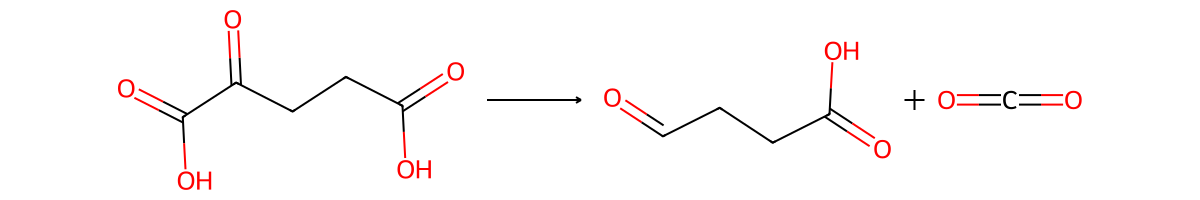

Reaction 2: Rb9871912c7a4f5cd92506c2a9963f2871a2d75851b654d5febfd5ea431227bc2


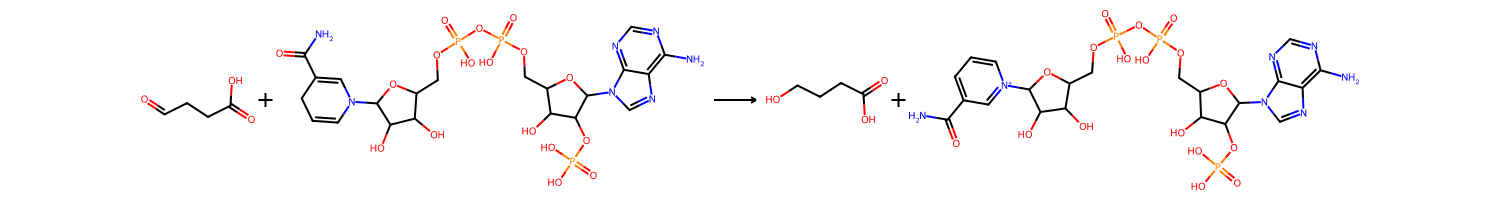

Reaction 3: Rc3dc4f7a2101ee38378b294d89e7a54540579108648e1bec436d8d9925c9a16f


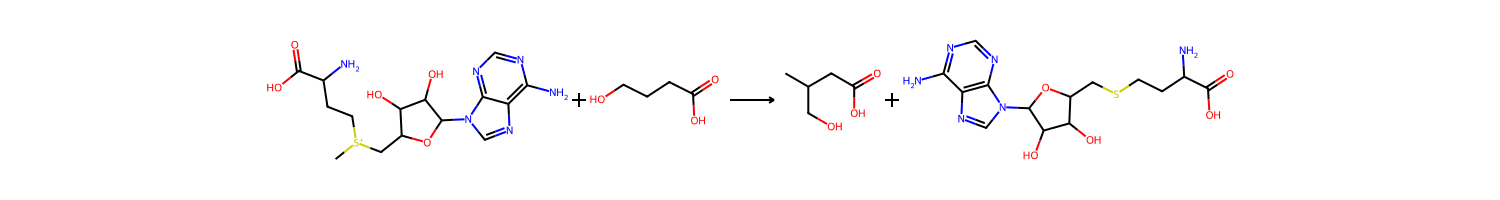

Reaction 4: R91837552f2faefa198c79c6e55d5f72a444f138a78649eb3dfe492e65bba19f3


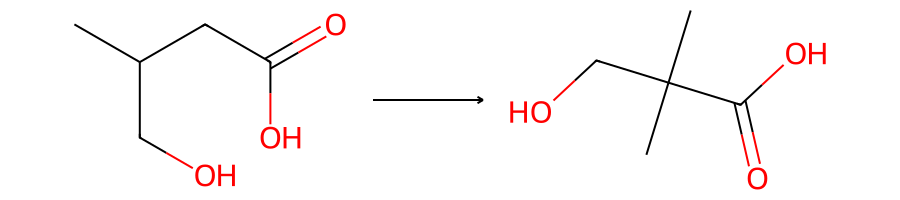

In [ ]:
pid = 'Pd5d98d1325c0dec9d4a1727451da133de045a2fe'
rids = paths.filter(pl.col("id") == pid)["reactions"].to_list()[0]
path = prs.filter(pl.col("id").is_in(rids)).sort(
    pl.col("id").replace({id: idx for idx, id in enumerate(rids)})
).select(pl.col("smarts"), pl.col("id"))
for i, row in enumerate(path.iter_rows(named=True)):
    print(f"Reaction {i+1}: {row['id']}")
    display(
        SVG(
            draw_reaction(row['smarts'])
        )
    )

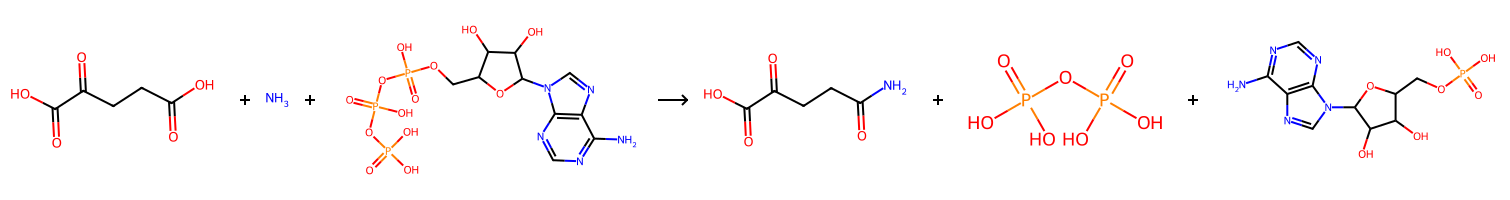

In [6]:
display(
    SVG(
        filename="/home/stef/quest_data/bottle/results/test/svgs/predicted/R24bedc4b9185ba54aa1bcb9b92b745fecf16f2f79df4e13b28dfd98de1600260.svg"
    )
)